# 🎯 Resume–Job Matching System
### End-to-End NLP Portfolio Project

**Stack:** Sentence Transformers · Cosine Similarity · Streamlit  
**Dataset:** Resume.csv — 2484 resumes · 24 categories  

---
## 📋 Table of Contents
1. [Setup & Imports](#step1)
2. [Step 1 — EDA](#step2)
3. [Step 2 — Preprocessing](#step3)
4. [Step 3 — Generate Embeddings](#step4)
5. [Step 4 — Matching & Evaluation](#step5)
6. [Step 5 — Live Demo (Match Any Resume)](#step6)


---
## ⚙️ Step 0 — Install Dependencies
> Run this cell once. Restart kernel after installation.

In [1]:
# ✅ STEP 0 — Run this cell FIRST before anything else
# It installs all required packages directly into your current kernel
import sys

!{sys.executable} -m pip install sentence-transformers --quiet
!{sys.executable} -m pip install pandas numpy scikit-learn --quiet
!{sys.executable} -m pip install matplotlib seaborn plotly --quiet
!{sys.executable} -m pip install nltk tqdm --quiet

print("✅ All packages installed successfully!")
print("⚠️  Now click: Kernel → Restart Kernel → then Run All Cells")

'e:\DOCS\ML' is not recognized as an internal or external command,
operable program or batch file.
'e:\DOCS\ML' is not recognized as an internal or external command,
operable program or batch file.
'e:\DOCS\ML' is not recognized as an internal or external command,
operable program or batch file.


✅ All packages installed successfully!
⚠️  Now click: Kernel → Restart Kernel → then Run All Cells


'e:\DOCS\ML' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import nltk
import os

# ✅ Create required folders
os.makedirs("data/raw",       exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("models",         exist_ok=True)

nltk.download("punkt",     quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet",   quiet=True)
nltk.download("punkt_tab", quiet=True)

print("✅ Folders created:")
print("   data/raw/       ✓")
print("   data/processed/ ✓")
print("   models/         ✓")
print("✅ NLTK data downloaded!")


✅ Folders created:
   data/raw/       ✓
   data/processed/ ✓
   models/         ✓
✅ NLTK data downloaded!


---
<a id='step2'></a>
## 📊 Step 1 — Exploratory Data Analysis
> **Goal:** Understand the dataset structure, category distribution, and text properties.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# ── Load Data ──────────────────────────────────────────
df = pd.read_csv('Resume.csv')

print('=' * 50)
print('  DATASET OVERVIEW')
print('=' * 50)
print(f'  Shape      : {df.shape[0]} rows × {df.shape[1]} columns')
print(f'  Columns    : {df.columns.tolist()}')
print(f'  Null values: {df.isnull().sum().sum()}')
print(f'  Duplicates : {df.duplicated().sum()}')
print(f'  Categories : {df["Category"].nunique()} unique')
df.head(3)

  DATASET OVERVIEW
  Shape      : 2484 rows × 4 columns
  Columns    : ['ID', 'Resume_str', 'Resume_html', 'Category']
  Null values: 0
  Duplicates : 0
  Categories : 24 unique


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR


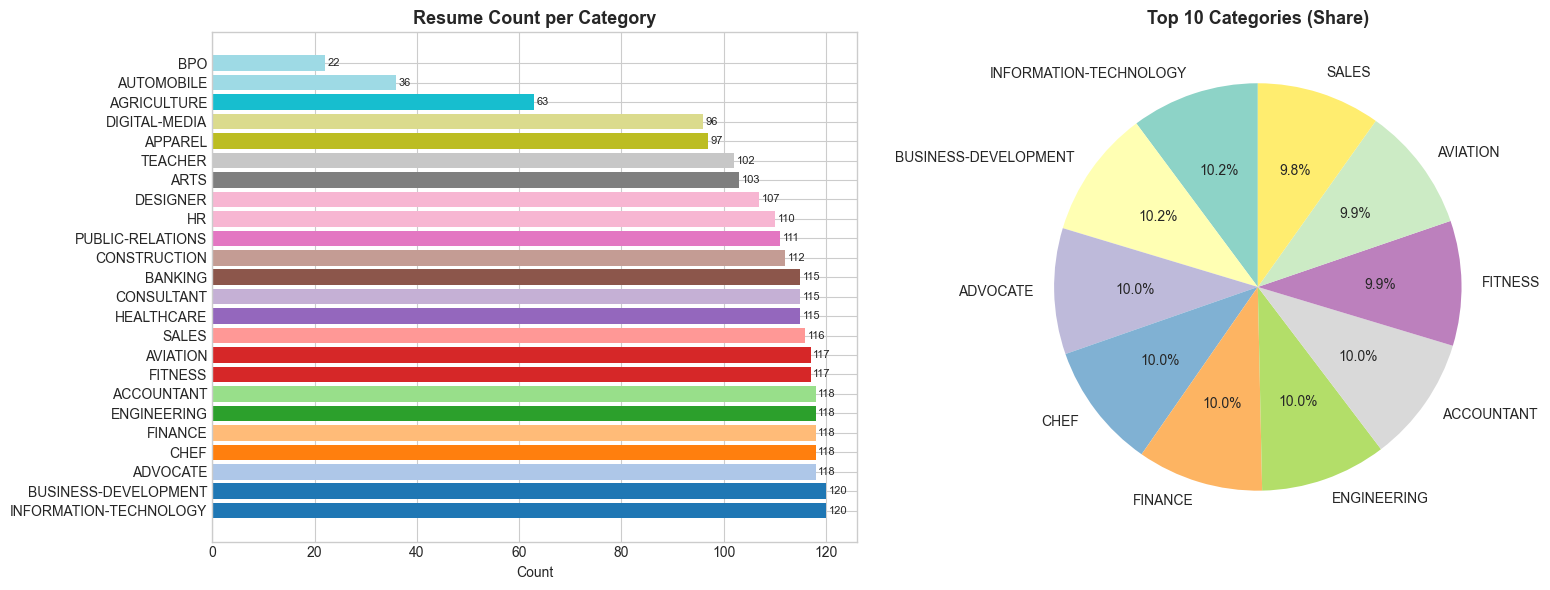

✅ Chart saved


In [6]:
# ── Category Distribution ──────────────────────────────
cat_counts = df['Category'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = plt.cm.tab20(np.linspace(0, 1, len(cat_counts)))
axes[0].barh(cat_counts.index, cat_counts.values, color=colors)
axes[0].set_title('Resume Count per Category', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Count')
for i, v in enumerate(cat_counts.values):
    axes[0].text(v + 0.5, i, str(v), va='center', fontsize=8)

# Pie chart - top 10
top10 = cat_counts.head(10)
axes[1].pie(top10.values, labels=top10.index, autopct='%1.1f%%',
            colors=plt.cm.Set3(np.linspace(0, 1, 10)), startangle=90)
axes[1].set_title('Top 10 Categories (Share)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('data/processed/eda_categories.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved')

📝 Word Count Statistics:
       word_count  char_count
count      2484.0      2484.0
mean        811.0      6295.0
std         371.0      2769.0
min           0.0        21.0
25%         651.0      5160.0
50%         757.0      5886.0
75%         933.0      7227.0
max        5190.0     38842.0


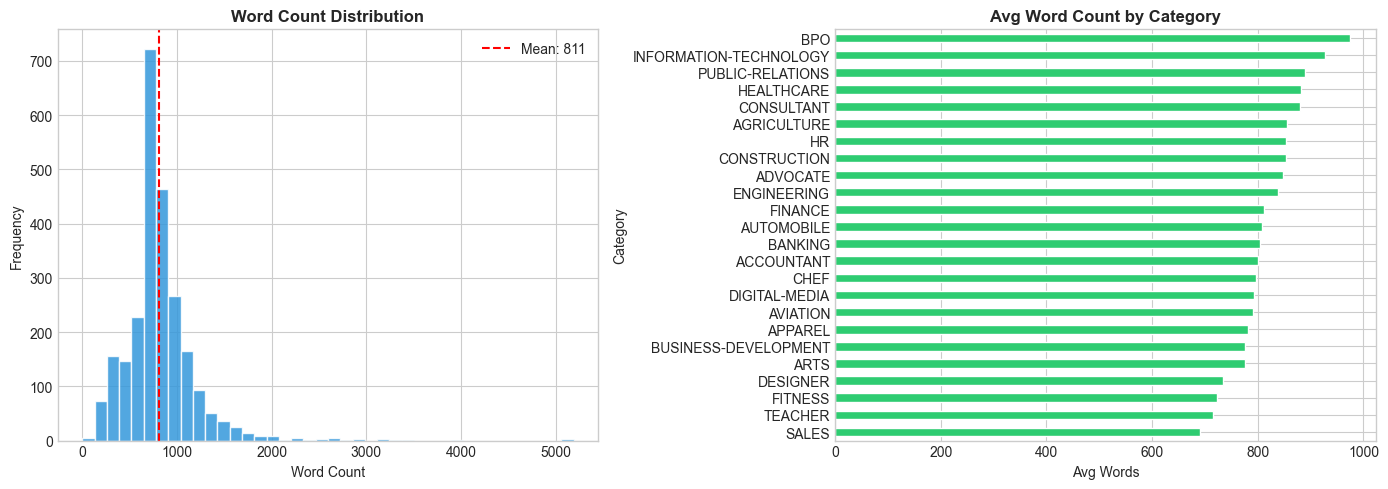

In [7]:
# ── Text Length Analysis ───────────────────────────────
df['word_count'] = df['Resume_str'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['Resume_str'].apply(len)

print('📝 Word Count Statistics:')
print(df[['word_count', 'char_count']].describe().round(0).to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['word_count'], bins=40, color='#3498DB', edgecolor='white', alpha=0.85)
axes[0].axvline(df['word_count'].mean(), color='red', linestyle='--',
                label=f"Mean: {df['word_count'].mean():.0f}")
axes[0].set_title('Word Count Distribution', fontweight='bold')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

df.groupby('Category')['word_count'].mean().sort_values().plot(
    kind='barh', ax=axes[1], color='#2ECC71', edgecolor='white')
axes[1].set_title('Avg Word Count by Category', fontweight='bold')
axes[1].set_xlabel('Avg Words')

plt.tight_layout()
plt.savefig('data/processed/eda_wordcount.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# ── Top TF-IDF Keywords per Category ──────────────────
from sklearn.feature_extraction.text import TfidfVectorizer

print('🔑 Top 5 keywords per category (TF-IDF):\n')
for cat in sorted(df['Category'].unique()):
    texts = df[df['Category'] == cat]['Resume_str'].astype(str).tolist()
    try:
        tfidf = TfidfVectorizer(stop_words='english', max_features=5, max_df=0.95)
        tfidf.fit(texts)
        kw = tfidf.get_feature_names_out().tolist()
        print(f'  {cat:<25}: {" · ".join(kw)}')
    except:
        pass

🔑 Top 5 keywords per category (TF-IDF):

  ACCOUNTANT               : accounts · financial · management · reports · tax
  ADVOCATE                 : customer · management · sales · service · team
  AGRICULTURE              : development · management · program · project · university
  APPAREL                  : customer · management · product · sales · store
  ARTS                     : arts · customer · management · school · students
  AUTOMOBILE               : city · customer · data · management · service
  AVIATION                 : aircraft · aviation · maintenance · management · training
  BANKING                  : business · customer · financial · management · sales
  BPO                      : business · city · client · state · team
  BUSINESS-DEVELOPMENT     : customer · management · marketing · new · sales
  CHEF                     : chef · food · kitchen · management · service
  CONSTRUCTION             : management · project · projects · safety · work
  CONSULTANT         

---
<a id='step3'></a>
## 🧹 Step 2 — Data Preprocessing
> **Goal:** Clean resume text, remove noise, extract skills, and create job descriptions for all 24 categories.

In [9]:
import re
import string
import os
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()

os.makedirs('data/processed', exist_ok=True)
os.makedirs('models', exist_ok=True)

STOP_WORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ''
    text = re.sub(r'http\S+|www\S+', ' ', text)      # remove URLs
    text = re.sub(r'\S+@\S+', ' ', text)              # remove emails
    text = re.sub(r'(\+?\d[\d\s\-().]{7,}\d)', ' ', text)  # remove phones
    text = re.sub(r'<[^>]+>', ' ', text)              # remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)      # keep alphanumeric
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in STOP_WORDS and len(t) > 2])

print('🧹 Cleaning text...')
clean_df = df[['ID', 'Category', 'Resume_str']].copy()
clean_df.rename(columns={'Resume_str': 'raw_text'}, inplace=True)
clean_df['clean_text']  = clean_df['raw_text'].progress_apply(clean_text)
clean_df['tokens_text'] = clean_df['clean_text'].progress_apply(remove_stopwords)

print(f'\n📊 Cleaning Stats:')
print(f'  Avg words (raw)   : {clean_df["raw_text"].apply(lambda x: len(str(x).split())).mean():.0f}')
print(f'  Avg words (clean) : {clean_df["clean_text"].apply(lambda x: len(str(x).split())).mean():.0f}')
clean_df.head(3)

🧹 Cleaning text...


100%|██████████| 2484/2484 [00:00<00:00, 11998.73it/s]



📊 Cleaning Stats:
  Avg words (raw)   : 811
  Avg words (clean) : 815


,ID,Category,raw_text,clean_text,tokens_text
0,16852973,HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administrator marketing associate hr admini...,administrator marketing associate administrato...
1,22323967,HR,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist us hr operations summary versati...,specialist operations summary versatile media ...
2,33176873,HR,HR DIRECTOR Summary Over 2...,hr director summary over 20 years experience i...,director summary years experience recruiting p...


In [10]:
# ── Extract Skill Keywords ─────────────────────────────
SKILL_KEYWORDS = [
    'python', 'java', 'sql', 'excel', 'machine learning', 'deep learning',
    'nlp', 'tensorflow', 'pytorch', 'scikit', 'pandas', 'numpy', 'spark',
    'hadoop', 'aws', 'azure', 'docker', 'kubernetes', 'git', 'javascript',
    'react', 'node', 'html', 'css', 'tableau', 'powerbi', 'scala',
    'communication', 'leadership', 'management', 'sales', 'marketing',
    'accounting', 'finance', 'healthcare', 'design', 'research',
    'c++', 'c#', 'php', 'swift', 'kotlin', 'matlab', 'sas',
]

def extract_skills(text):
    t = text.lower()
    return ', '.join([s for s in SKILL_KEYWORDS if s in t])

clean_df['skills'] = clean_df['raw_text'].progress_apply(extract_skills)

# Show skill coverage
has_skills = (clean_df['skills'] != '').sum()
print(f'✅ Resumes with detected skills: {has_skills}/{len(clean_df)} ({has_skills/len(clean_df)*100:.1f}%)')
print('\nSample skills extracted:')
clean_df[['Category','skills']].dropna().head(5)

100%|██████████| 2484/2484 [00:00<00:00, 6588.08it/s]

✅ Resumes with detected skills: 2469/2484 (99.4%)

Sample skills extracted:


,Category,skills
0,HR,"aws, leadership, management, sales, marketing,..."
1,HR,"git, communication, management, sales, marketi..."
2,HR,"excel, leadership, management, marketing, heal..."
3,HR,"excel, communication, management"
4,HR,"excel, aws, leadership, management"


In [11]:
# ── Create Job Descriptions for 24 Categories ─────────
JOB_DESCRIPTIONS = {
    'INFORMATION-TECHNOLOGY': 'Skilled IT professional with software development, Python, Java, SQL, cloud platforms AWS Azure, networking, and cybersecurity experience.',
    'BUSINESS-DEVELOPMENT':   'Business Development Manager to build client relationships, negotiate contracts, drive revenue. Strong CRM and strategic planning skills.',
    'ADVOCATE':               'Legal professional with litigation, contract drafting, legal research, and client counseling experience.',
    'CHEF':                   'Experienced Chef with culinary arts, menu planning, kitchen management, food safety, and team leadership skills.',
    'FINANCE':                'Finance professional with financial analysis, budgeting, forecasting, accounting, Excel, and ERP systems experience.',
    'ENGINEERING':            'Engineer with CAD, project management, quality control, and technical problem-solving skills.',
    'ACCOUNTANT':             'Accountant with bookkeeping, tax preparation, financial statements, auditing, and QuickBooks expertise.',
    'FITNESS':                'Fitness Trainer with personal training certification, nutrition counseling, and program design skills.',
    'AVIATION':               'Aviation professional with pilot license or aviation management, FAA regulations, and flight operations knowledge.',
    'SALES':                  'Sales professional with prospecting, negotiation, CRM Salesforce, and proven track record of exceeding targets.',
    'HEALTHCARE':             'Healthcare professional with clinical knowledge, patient care, EMR systems, and HIPAA compliance experience.',
    'CONSULTANT':             'Consultant with analytical thinking, client management, project delivery, and strong presentation skills.',
    'BANKING':                'Banking professional with financial products knowledge, risk assessment, regulatory compliance, and customer service.',
    'CONSTRUCTION':           'Construction professional with project management, blueprint reading, site supervision, and OSHA compliance.',
    'PUBLIC-RELATIONS':       'PR specialist with media relations, press releases, crisis communication, and social media management.',
    'HR':                     'HR professional with talent acquisition, employee relations, performance management, and labor law compliance.',
    'DESIGNER':               'Designer proficient in Adobe Creative Suite, UI UX, Figma, branding, and responsive design.',
    'ARTS':                   'Arts professional with creative portfolio, exhibition experience, and collaboration skills.',
    'TEACHER':                'Teacher with curriculum development, classroom management, lesson planning, and teaching certification.',
    'APPAREL':                'Apparel professional with fashion design, textile knowledge, trend forecasting, and merchandising skills.',
    'DIGITAL-MEDIA':          'Digital Media specialist with content creation, video editing, SEO, and social media strategy.',
    'AGRICULTURE':            'Agriculture professional with crop science, farm management, irrigation, and sustainable practice knowledge.',
    'AUTOMOBILE':             'Automobile professional with vehicle mechanics, diagnostics, auto repair, and customer service expertise.',
    'BPO':                    'BPO professional with strong communication, customer service, data processing, and call center operations experience.',
}

jobs_df = pd.DataFrame([
    {'job_id': i+1, 'job_title': k, 'job_description': v}
    for i, (k, v) in enumerate(JOB_DESCRIPTIONS.items())
])

# Save both files
clean_df.to_csv('data/processed/resumes_clean.csv', index=False)
jobs_df.to_csv('data/processed/job_descriptions.csv', index=False)

print(f'💾 Saved: data/processed/resumes_clean.csv  ({len(clean_df)} rows)')
print(f'💾 Saved: data/processed/job_descriptions.csv ({len(jobs_df)} jobs)')
jobs_df

💾 Saved: data/processed/resumes_clean.csv  (2484 rows)
💾 Saved: data/processed/job_descriptions.csv (24 jobs)


,job_id,job_title,job_description
0,1,INFORMATION-TECHNOLOGY,Skilled IT professional with software developm...
1,2,BUSINESS-DEVELOPMENT,Business Development Manager to build client r...
2,3,ADVOCATE,"Legal professional with litigation, contract d..."
3,4,CHEF,"Experienced Chef with culinary arts, menu plan..."
4,5,FINANCE,"Finance professional with financial analysis, ..."
5,6,ENGINEERING,"Engineer with CAD, project management, quality..."
6,7,ACCOUNTANT,"Accountant with bookkeeping, tax preparation, ..."
7,8,FITNESS,Fitness Trainer with personal training certifi...
8,9,AVIATION,Aviation professional with pilot license or av...
9,10,SALES,"Sales professional with prospecting, negotiati..."


---
<a id='step4'></a>
## 🤖 Step 3 — Generate Sentence Embeddings
> **Goal:** Convert resume and job description text into 384-dimensional semantic vectors using `all-MiniLM-L6-v2`.

> ⏳ **First run:** Downloads ~80MB model. After that it's cached locally.

In [12]:
import pickle
import time
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load model (downloads on first run, cached after)
print('📥 Loading Sentence Transformer model...')
print('   Model: all-MiniLM-L6-v2')
print('   Size : ~80MB (cached after first download)')

model = SentenceTransformer('all-MiniLM-L6-v2')
print(f'✅ Model loaded | Embedding dimension: {model.get_sentence_embedding_dimension()}')

📥 Loading Sentence Transformer model...
   Model: all-MiniLM-L6-v2
   Size : ~80MB (cached after first download)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded | Embedding dimension: 384


In [13]:
# ── Encode Resumes ────────────────────────────────────
resume_texts = clean_df['clean_text'].fillna('').tolist()

print(f'🔄 Encoding {len(resume_texts)} resumes...')
print('   (This takes 2–5 minutes depending on your CPU)\n')

t0 = time.time()
resume_embeddings = model.encode(
    resume_texts,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True,
)
t1 = time.time()

print(f'\n✅ Resume embeddings shape : {resume_embeddings.shape}')
print(f'   Time taken              : {t1-t0:.1f}s')

🔄 Encoding 2484 resumes...
   (This takes 2–5 minutes depending on your CPU)



Batches:   0%|          | 0/39 [00:00<?, ?it/s]


✅ Resume embeddings shape : (2484, 384)
   Time taken              : 43.5s


In [14]:
# ── Encode Job Descriptions ───────────────────────────
job_texts = jobs_df['job_description'].tolist()

print(f'🔄 Encoding {len(job_texts)} job descriptions...')

t0 = time.time()
job_embeddings = model.encode(
    job_texts,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True,
)
t1 = time.time()

print(f'\n✅ Job embeddings shape : {job_embeddings.shape}')
print(f'   Time taken          : {t1-t0:.1f}s')

# Save embeddings to disk
with open('models/resume_embeddings.pkl', 'wb') as f:
    pickle.dump(resume_embeddings, f)

with open('models/job_embeddings.pkl', 'wb') as f:
    pickle.dump(job_embeddings, f)

print('\n💾 Saved: models/resume_embeddings.pkl')
print('💾 Saved: models/job_embeddings.pkl')

🔄 Encoding 24 job descriptions...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Job embeddings shape : (24, 384)
   Time taken          : 0.1s

💾 Saved: models/resume_embeddings.pkl
💾 Saved: models/job_embeddings.pkl


In [15]:
# ── Sanity Check ──────────────────────────────────────
print('🧪 Sanity Check — IT resume vs all jobs:\n')

it_idx  = clean_df[clean_df['Category'] == 'INFORMATION-TECHNOLOGY'].index[0]
r_emb   = resume_embeddings[it_idx].reshape(1, -1)
scores  = cosine_similarity(r_emb, job_embeddings)[0]
top3    = np.argsort(scores)[::-1][:3]

print(f'  Resume category: INFORMATION-TECHNOLOGY')
print(f'  Top 3 job matches:')
for rank, idx in enumerate(top3, 1):
    print(f'    #{rank}  {jobs_df.iloc[idx]["job_title"]:<30} → {scores[idx]*100:.1f}%')
print('\n✅ If IT shows as #1 → embeddings are working correctly!')

🧪 Sanity Check — IT resume vs all jobs:

  Resume category: INFORMATION-TECHNOLOGY
  Top 3 job matches:
    #1  INFORMATION-TECHNOLOGY         → 35.7%
    #2  SALES                          → 35.5%
    #3  CONSTRUCTION                   → 34.6%

✅ If IT shows as #1 → embeddings are working correctly!


---
<a id='step5'></a>
## 📈 Step 4 — Matching & Evaluation
> **Goal:** Match all 2484 resumes to the 24 jobs, measure Top-1/3/5 accuracy, and visualize results.

In [16]:
# ── Build Full Similarity Matrix ─────────────────────
print('⚙️  Computing 2484 × 24 similarity matrix...')
sim_matrix = cosine_similarity(resume_embeddings, job_embeddings)
print(f'✅ Similarity matrix shape: {sim_matrix.shape}  (resumes × jobs)')

# Top match for each resume
top1_idx    = np.argmax(sim_matrix, axis=1)
top1_title  = jobs_df.iloc[top1_idx]['job_title'].values
top1_score  = sim_matrix[np.arange(len(clean_df)), top1_idx]

results_df = clean_df[['ID','Category']].copy()
results_df['predicted_job'] = top1_title
results_df['match_score']   = (top1_score * 100).round(2)
results_df.head(8)

⚙️  Computing 2484 × 24 similarity matrix...
✅ Similarity matrix shape: (2484, 24)  (resumes × jobs)


,ID,Category,predicted_job,match_score
0,16852973,HR,HR,54.480000
1,22323967,HR,HR,55.279999
2,33176873,HR,HR,47.880001
3,27018550,HR,HR,46.480000
4,17812897,HR,HR,62.110001
5,11592605,HR,HR,46.480000
6,25824789,HR,HR,59.740002
7,15375009,HR,HR,58.720001


In [17]:
# ── Accuracy Metrics ─────────────────────────────────
def topk_accuracy(sim_matrix, true_labels, job_titles, k):
    correct = 0
    for i in range(len(true_labels)):
        top_k = np.argsort(sim_matrix[i])[::-1][:k]
        if true_labels[i] in job_titles[top_k]:
            correct += 1
    return correct / len(true_labels)

true_labels = clean_df['Category'].values
job_title_arr = jobs_df['job_title'].values

top1 = topk_accuracy(sim_matrix, true_labels, job_title_arr, 1)
top3 = topk_accuracy(sim_matrix, true_labels, job_title_arr, 3)
top5 = topk_accuracy(sim_matrix, true_labels, job_title_arr, 5)

print('=' * 40)
print('  EVALUATION RESULTS')
print('=' * 40)
print(f'  Top-1 Accuracy : {top1*100:.2f}%')
print(f'  Top-3 Accuracy : {top3*100:.2f}%')
print(f'  Top-5 Accuracy : {top5*100:.2f}%')
print(f'  Avg Match Score: {results_df["match_score"].mean():.2f}%')
print('=' * 40)

  EVALUATION RESULTS
  Top-1 Accuracy : 52.58%
  Top-3 Accuracy : 70.69%
  Top-5 Accuracy : 78.99%
  Avg Match Score: 46.09%


In [19]:
# Fix - rebuild results_df with Category column
results_df = clean_df[['ID', 'Category']].copy()
results_df['predicted_job'] = top1_title
results_df['match_score']   = (top1_score * 100).round(2)
print(results_df.columns.tolist())
print(results_df.head(3))

['ID', 'Category', 'predicted_job', 'match_score']
         ID Category predicted_job  match_score
0  16852973       HR            HR    54.480000
1  22323967       HR            HR    55.279999
2  33176873       HR            HR    47.880001


In [22]:
print(results_df.columns.tolist())
print(results_df.head(2))

['ID', 'Category', 'predicted_job', 'match_score']
         ID Category predicted_job  match_score
0  16852973       HR            HR    54.480000
1  22323967       HR            HR    55.279999


📊 Per-Category Top-1 Accuracy:

Category
HR                        0.964
ACCOUNTANT                0.932
TEACHER                   0.882
CHEF                      0.873
CONSTRUCTION              0.866
BUSINESS-DEVELOPMENT      0.717
ENGINEERING               0.627
BANKING                   0.583
FITNESS                   0.530
HEALTHCARE                0.504
SALES                     0.491
PUBLIC-RELATIONS          0.477
CONSULTANT                0.452
INFORMATION-TECHNOLOGY    0.433
DESIGNER                  0.393
DIGITAL-MEDIA             0.354
FINANCE                   0.347
AVIATION                  0.333
BPO                       0.318
AGRICULTURE               0.302
APPAREL                   0.247
ADVOCATE                  0.136
ARTS                      0.126
AUTOMOBILE                0.111


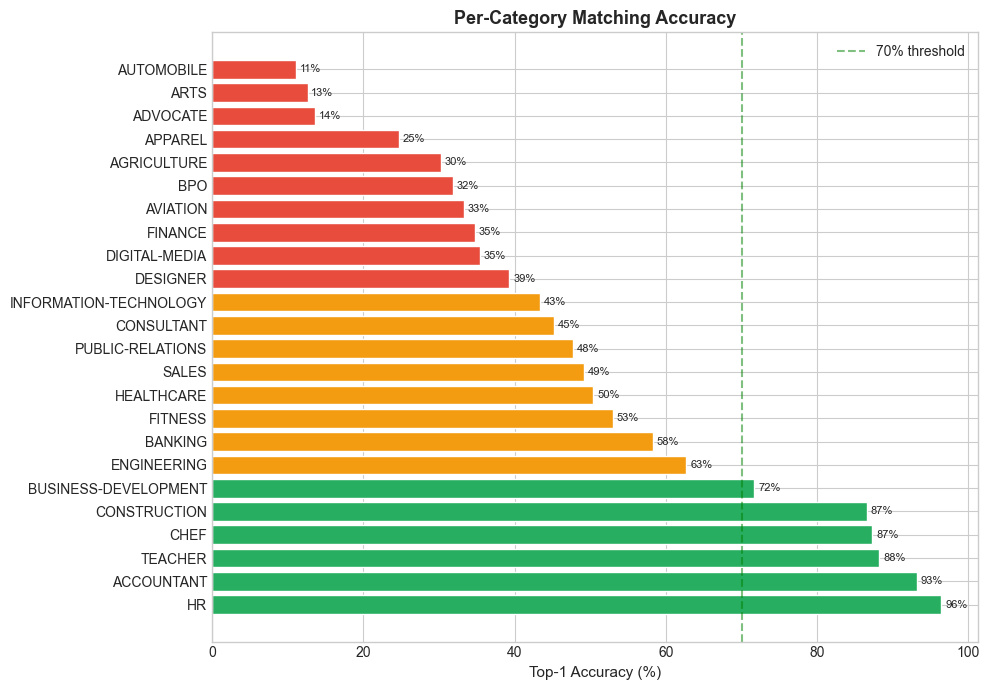

✅ Done!


In [23]:
# ── Per-Category Accuracy (fixed) ─────────────────────────
cat_acc = (
    results_df
    .assign(correct=results_df["Category"] == results_df["predicted_job"])
    .groupby("Category")["correct"]
    .mean()
    .round(3)
    .sort_values(ascending=False)
)

print("📊 Per-Category Top-1 Accuracy:\n")
print(cat_acc.to_string())

# ── Bar Chart ──────────────────────────────────────────────
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#27AE60' if v >= 0.7 else '#F39C12' if v >= 0.4 else '#E74C3C'
          for v in cat_acc.values]
bars = ax.barh(cat_acc.index, cat_acc.values * 100, color=colors, edgecolor='white')
ax.axvline(70, color='green', linestyle='--', alpha=0.5, label='70% threshold')
ax.set_xlabel('Top-1 Accuracy (%)', fontsize=11)
ax.set_title('Per-Category Matching Accuracy', fontsize=13, fontweight='bold')
for bar, v in zip(bars, cat_acc.values):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{v*100:.0f}%', va='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('data/processed/per_category_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Done!")

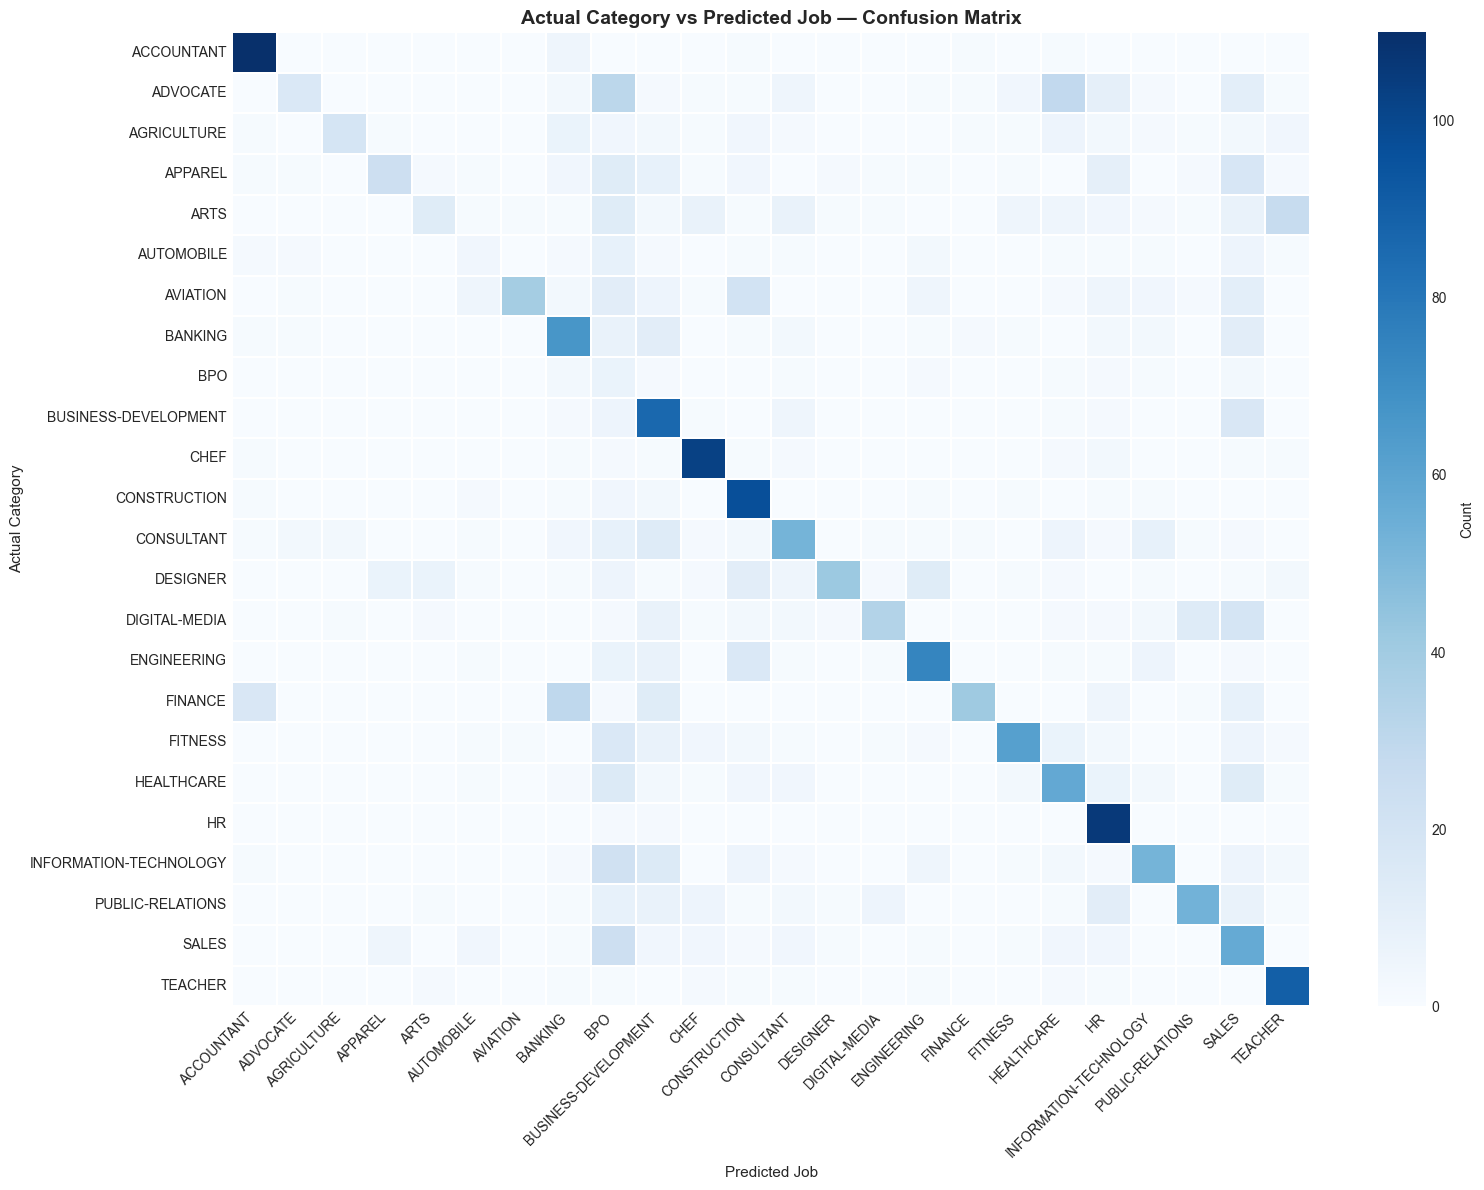

💾 Saved confusion heatmap


In [24]:
# ── Confusion Heatmap ────────────────────────────────
conf = results_df.groupby(['Category','predicted_job']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(conf, cmap='Blues', linewidths=0.3,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title('Actual Category vs Predicted Job — Confusion Matrix',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Job', fontsize=11)
ax.set_ylabel('Actual Category', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('data/processed/confusion_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('💾 Saved confusion heatmap')

🎨 Running t-SNE (takes ~1 min)...


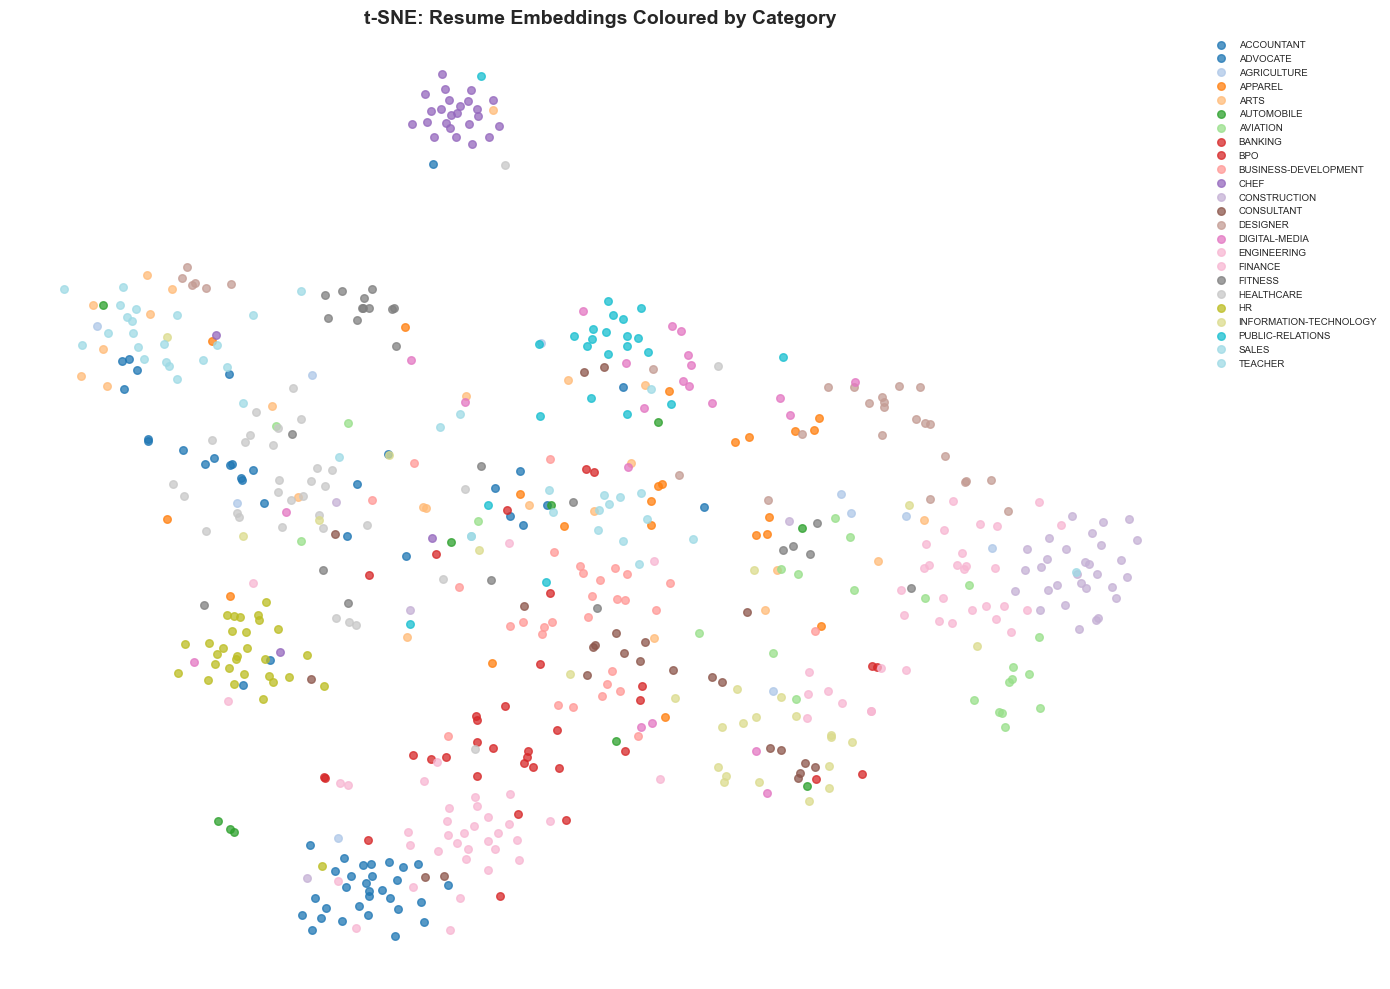

✅ t-SNE visualization saved!


In [26]:
# ── t-SNE Embedding Visualization ────────────────────────
from sklearn.manifold import TSNE

print('🎨 Running t-SNE (takes ~1 min)...')
sample_n   = min(600, len(clean_df))
sample_idx = np.random.choice(len(clean_df), sample_n, replace=False)
s_embs     = resume_embeddings[sample_idx]
s_cats     = clean_df.iloc[sample_idx]['Category'].values

# ✅ Fixed: use max_iter instead of n_iter (scikit-learn >= 1.2)
tsne  = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
e2d   = tsne.fit_transform(s_embs)

unique_cats = sorted(set(s_cats))
cmap        = plt.cm.tab20(np.linspace(0, 1, len(unique_cats)))
cmap_dict   = {c: cmap[i] for i, c in enumerate(unique_cats)}

fig, ax = plt.subplots(figsize=(14, 10))
for cat in unique_cats:
    mask = s_cats == cat
    ax.scatter(e2d[mask,0], e2d[mask,1], c=[cmap_dict[cat]],
               label=cat, alpha=0.75, s=30)

ax.set_title('t-SNE: Resume Embeddings Coloured by Category',
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.01,1), loc='upper left', fontsize=7)
ax.axis('off')
plt.tight_layout()
plt.savefig('data/processed/tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ t-SNE visualization saved!')

---
<a id='step6'></a>
## 🚀 Step 5 — Live Demo: Match Any Resume
> **Paste any resume below and instantly see the top matching jobs with scores and skill gap analysis.**

In [27]:
# ═══════════════════════════════════════════════════
# PASTE YOUR RESUME TEXT HERE ↓
# ═══════════════════════════════════════════════════

MY_RESUME = """
Data Scientist with 3 years of experience.
Skills: Python, Machine Learning, NLP, TensorFlow, SQL, Pandas, AWS.
Built recommendation systems and deployed REST APIs using FastAPI and Docker.
Education: B.Tech Computer Science.
"""

TOP_K = 5   # how many top matches to show
# ═══════════════════════════════════════════════════

In [28]:
import re as _re

def _clean(text):
    text = _re.sub(r'http\S+|www\S+', ' ', str(text))
    text = _re.sub(r'\S+@\S+', ' ', text)
    text = _re.sub(r'<[^>]+>', ' ', text)
    text = _re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return _re.sub(r'\s+', ' ', text).lower().strip()

SKILLS = [
    'python','java','sql','excel','machine learning','deep learning','nlp',
    'tensorflow','pytorch','pandas','numpy','spark','aws','azure','docker',
    'kubernetes','git','javascript','react','tableau','powerbi',
    'communication','leadership','management','sales','marketing',
    'accounting','finance','healthcare','design','research',
]

# Encode resume
r_clean = _clean(MY_RESUME)
r_emb   = model.encode([r_clean], normalize_embeddings=True)
scores  = cosine_similarity(r_emb, job_embeddings)[0]
top_idx = np.argsort(scores)[::-1][:TOP_K]

print('=' * 55)
print(f'  TOP {TOP_K} MATCHING JOBS FOR YOUR RESUME')
print('=' * 55)

for rank, idx in enumerate(top_idx, 1):
    s = scores[idx] * 100
    icon = '🟢' if s >= 70 else '🟡' if s >= 50 else '🟠' if s >= 35 else '🔴'
    print(f'  #{rank}  {icon}  {jobs_df.iloc[idx]["job_title"]:<30}  {s:.1f}%')

print('\n  Score Guide: 🟢 Excellent (70%+)  🟡 Good (50%)  🟠 Fair (35%)  🔴 Low')

  TOP 5 MATCHING JOBS FOR YOUR RESUME
  #1  🟡  INFORMATION-TECHNOLOGY          52.8%
  #2  🔴  SALES                           33.0%
  #3  🔴  ACCOUNTANT                      31.0%
  #4  🔴  FINANCE                         30.6%
  #5  🔴  DIGITAL-MEDIA                   29.0%

  Score Guide: 🟢 Excellent (70%+)  🟡 Good (50%)  🟠 Fair (35%)  🔴 Low


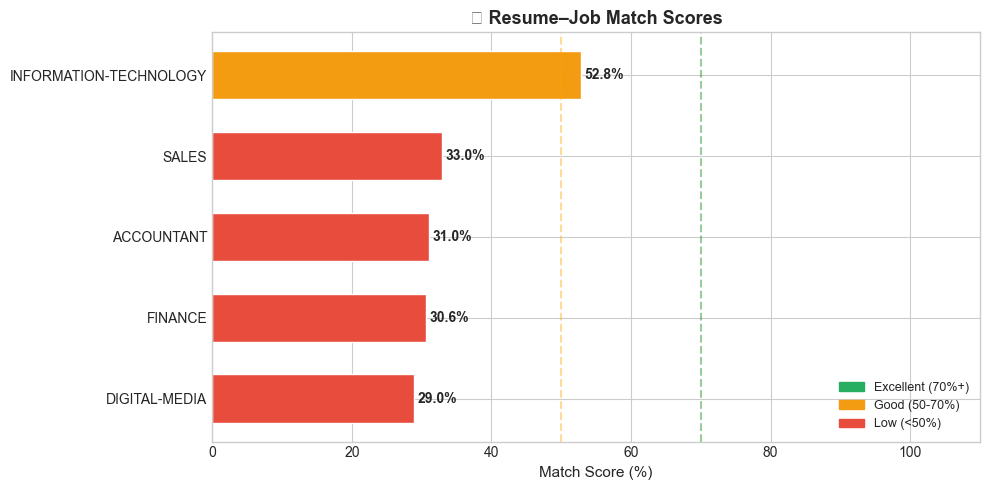

In [29]:
# ── Match Score Bar Chart ────────────────────────────
import matplotlib.patches as mpatches

top_titles = [jobs_df.iloc[i]['job_title'] for i in top_idx]
top_scores = [scores[i] * 100 for i in top_idx]
bar_colors = ['#27AE60' if s >= 70 else '#F39C12' if s >= 50 else '#E74C3C'
              for s in top_scores]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(top_titles[::-1], top_scores[::-1],
               color=bar_colors[::-1], edgecolor='white', height=0.6)
for bar, score in zip(bars, top_scores[::-1]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{score:.1f}%', va='center', fontsize=10, fontweight='bold')
ax.set_xlim(0, 110)
ax.set_xlabel('Match Score (%)', fontsize=11)
ax.set_title('🎯 Resume–Job Match Scores', fontsize=13, fontweight='bold')
ax.axvline(70, color='green', linestyle='--', alpha=0.4, label='70% threshold')
ax.axvline(50, color='orange', linestyle='--', alpha=0.4)
legend = [
    mpatches.Patch(color='#27AE60', label='Excellent (70%+)'),
    mpatches.Patch(color='#F39C12', label='Good (50-70%)'),
    mpatches.Patch(color='#E74C3C', label='Low (<50%)'),
]
ax.legend(handles=legend, loc='lower right', fontsize=9)
plt.tight_layout()
plt.show()


🧩 Skill Gap Analysis — Top Match: INFORMATION-TECHNOLOGY
   Skill Match  : 60.0%  (3/5 skills)
   ✅ Matched   : python · sql · aws
   ❌ Missing   : java · azure



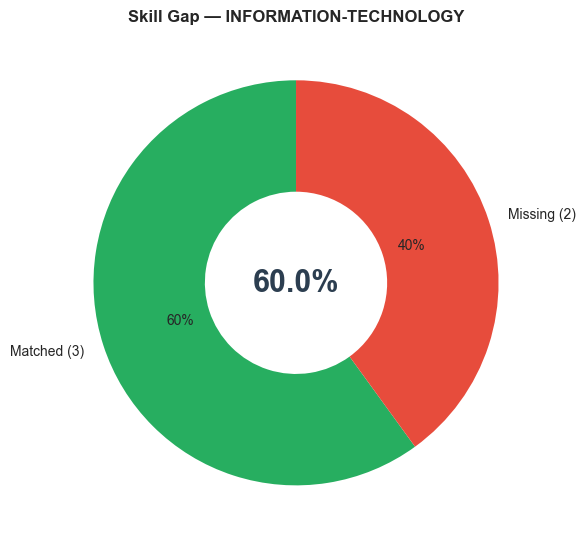

In [30]:
# ── Skill Gap Analysis (Top Match) ───────────────────
best_job  = jobs_df.iloc[top_idx[0]]
job_text  = best_job['job_description'].lower()
res_text  = MY_RESUME.lower()

required = [s for s in SKILLS if s in job_text]
matched  = [s for s in required if s in res_text]
missing  = [s for s in required if s not in res_text]
pct      = round(len(matched)/len(required)*100, 1) if required else 0

print(f'\n🧩 Skill Gap Analysis — Top Match: {best_job["job_title"]}')
print(f'   Skill Match  : {pct}%  ({len(matched)}/{len(required)} skills)')
print(f'   ✅ Matched   : {" · ".join(matched) if matched else "None"}')
print(f'   ❌ Missing   : {" · ".join(missing) if missing else "None — Perfect!"}\n')

# Pie chart
fig, ax = plt.subplots(figsize=(6, 6))
vals   = [len(matched), max(1, len(missing))]
labels = [f'Matched ({len(matched)})', f'Missing ({len(missing)})']
clrs   = ['#27AE60', '#E74C3C']
wedges, texts, autotexts = ax.pie(
    vals, labels=labels, colors=clrs,
    autopct='%1.0f%%', startangle=90,
    wedgeprops=dict(width=0.55)
)
ax.text(0, 0, f'{pct}%', ha='center', va='center',
        fontsize=22, fontweight='bold', color='#2C3E50')
ax.set_title(f'Skill Gap — {best_job["job_title"]}',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🏁 Project Complete!

### ✅ What You Built
| Component | Details |
|---|---|
| Dataset | 2484 resumes · 24 categories |
| Model | `all-MiniLM-L6-v2` · 384-dim embeddings |
| Matching | Cosine Similarity |
| Evaluation | Top-1 / Top-3 / Top-5 Accuracy |
| Outputs | Match results CSV · Confusion heatmap · t-SNE plot |

### 📁 Output Files Generated
```
data/processed/
  ├── resumes_clean.csv         ← cleaned resumes
  ├── job_descriptions.csv      ← 24 job descriptions
  ├── match_results.csv         ← resume→job matches
  ├── eda_categories.png
  ├── eda_wordcount.png
  ├── per_category_accuracy.png
  ├── confusion_heatmap.png
  └── tsne_visualization.png
models/
  ├── resume_embeddings.pkl
  └── job_embeddings.pkl
```
### 🚀 Next Steps for Portfolio
- Deploy the Streamlit app to **Render** or **HuggingFace Spaces** (free)
- Add it to your GitHub with a nice README
- Record a short demo video for LinkedIn
